In [78]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

# WirVsVirus Hackathon

Die entscheidende Frage bei der Beurteilung aller Maßnahmen ist, ob das exponentielle Wachstum verlangsamt worden ist, d.h. die exponentielle Wachstumskurve abflacht.
Dazu macht man am besten anhand bestehender Daten ein Modell-Fit und schaut, ob aktuelle Fallzahlen das Modell überschreiten oder man mit den Fallzahlen darunter bleibt.

## Download Data from CSSE COVID-19 Dataset

We are using the Covid-19 Dataset: https://github.com/CSSEGISandData/COVID-19

In [79]:
url = 'https://raw.githubusercontent.com'
url += '/CSSEGISandData/COVID-19'
url += '/master/csse_covid_19_data/csse_covid_19_time_series'
url += '/time_series_19-covid-Confirmed.csv'

In [80]:
confirmed = pd.read_csv(url)

In [81]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,59,70,75,82,114,147,177,212,272,322
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,639,701,773,839,825,878,889,924,963
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,178,200,212,226,243,266,313,345,385
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,149,197,238,428,566,673,790,900,1030


### Preprocessing

In [82]:
ger_confirmed = confirmed[confirmed['Country/Region']=='Germany'].T
ger_confirmed = ger_confirmed[4:].astype('int')
ger_confirmed.columns = ['confirmed']

In [83]:
ger_confirmed.index = pd.to_datetime(ger_confirmed.index)
ger_confirmed = ger_confirmed.asfreq('D')

In [84]:
ger_confirmed = ger_confirmed[ger_confirmed.confirmed>100]

In [85]:
today = ger_confirmed.index[-1]

## Feature

In [86]:
ger_confirmed['days'] = (ger_confirmed.index - ger_confirmed.index.min()).days

In [87]:
ger_confirmed.head()

,confirmed,days
2020-03-01,130,0
2020-03-02,159,1
2020-03-03,196,2
2020-03-04,262,3
2020-03-05,482,4


## Prediction Model

In [88]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [89]:
X = ger_confirmed['days'].values.reshape(-1, 1)
y = ger_confirmed['confirmed'].values
logy = np.log(y)

### Train

In [90]:
clf = LinearRegression()
clf.fit(X, logy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [91]:
logy_pred = clf.predict(X)
ger_confirmed['predicted'] = np.exp(logy_pred).astype('int')

In [92]:
ger_confirmed.tail()

,confirmed,days,predicted
2020-03-16,7272,15,7329
2020-03-17,9257,16,9546
2020-03-18,12327,17,12434
2020-03-19,15320,18,16194
2020-03-20,19848,19,21093


## Plot

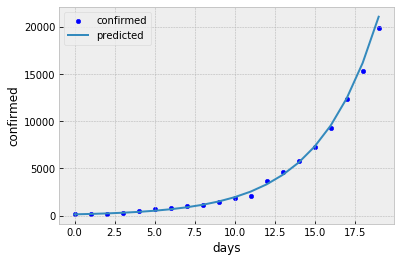

In [93]:
ax = ger_confirmed.plot(kind='scatter', x='days', y='confirmed', label='confirmed')
ger_confirmed.plot(x='days', y='predicted', label='predicted', ax=ax)

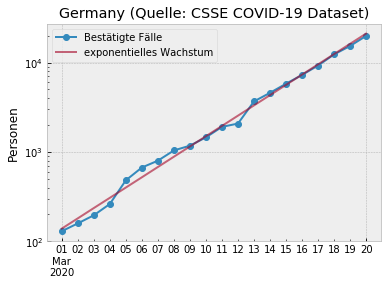

In [94]:
ax = ger_confirmed['confirmed'].plot(label=u'Bestätigte Fälle', marker='o')
ax = ger_confirmed['predicted'].plot(label=u'exponentielles Wachstum', alpha=0.6, ax=ax)
ax.legend()
ax.set_ylabel('Personen');
ax.set_yscale('log')
ax.set_title('Germany (Quelle: CSSE COVID-19 Dataset)');

## Save the model for later use

In [95]:
import pickle

with open('%s-Germany-Covid19-Prediction-Model.pkl' % today.strftime('%Y-%m-%d'), 'wb') as f:
    pickle.dump(clf, f)

## Future

In [96]:
fd = 13 # days into the future

In [97]:
# Create DataFrame in the Future
dates = pd.date_range(ger_confirmed.index[-1], periods=fd, closed='right')
days_in_future = ger_confirmed.days[-1] + np.arange(1, fd)

future = pd.DataFrame(data=days_in_future, index=dates, columns=['days'])

In [98]:
ger_future = ger_confirmed.append(future, sort=True)

### Predict the Future

In [99]:
X_future = ger_future['days'].values.reshape(-1, 1)

In [100]:
logy_pred = clf.predict(X_future)
ger_future['predicted'] = np.exp(logy_pred).astype('int')

## Future Plot

In [101]:
title = 'Bestätigte Fälle und Vorhersage für Deutschland (Basierend auf CSSE COVID-19 Dataset)'

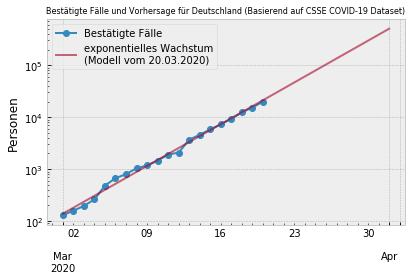

In [102]:
ax = ger_future['confirmed'].plot(label='Bestätigte Fälle', marker='o')
ax = ger_future['predicted'].plot(label='exponentielles Wachstum\n(Modell vom %s)' % today.strftime('%d.%m.%Y'),
                                  alpha=0.6, ax=ax)

ax.legend()
ax.set_ylabel('Personen');
ax.set_yscale('log')
ax.set_title(title, fontsize=8);

plt.tight_layout()
plt.savefig('./%s-Germany-Covid19-Prediction.png' % today.strftime('%Y-%m-%d'), dpi=150)

# Interactive Website

We are using Bokeh to export an interactive website

In [103]:
from bokeh.plotting import figure
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models import BoxAnnotation
from bokeh.models import Div
from bokeh.layouts import column
from bokeh.io import output_file, show

In [104]:
p = figure(plot_width=1280, plot_height=720,
           x_axis_type="datetime", y_axis_type="log",
           title=title)

p.line(ger_future.index, ger_future.predicted, line_width=5,
       legend='exponentielles Wachstum\n(Modell vom %s)' % today.strftime('%d.%m.%Y'))

p.circle(ger_confirmed.index, ger_confirmed.confirmed,
         fill_color="white", size=12, legend='Bestätigte Fälle')

p.xaxis.formatter=DatetimeTickFormatter(
    years="%d.%m.%Y",
    months="%d.%m.%Y",
    days="%A %d.%m.%Y",
)

gray_box = BoxAnnotation(left=ger_confirmed.index[0],
                          right=ger_confirmed.index[-1],
                          fill_color='gray', fill_alpha=0.1)
p.add_layout(gray_box)

p.legend.location = "top_left"

div = Div(text="""Quellcode: <a href="https://github.com/balzer82/covid-germany-predictor">Covid Germany Predictor</a> unter CC-BY2.0 Lizenz on Github.""",
width=600, height=100)

show(column(p, div))

output_file("index.html")

CC-BY 2.0 Paul Balzer